In [1]:
import  matplotlib
import  pickle
import  os
import  json
import  copy
import  tensorflow         as      tf

In [11]:
from    tensorflow.keras.utils                import  to_categorical
from    tensorflow.keras.models               import  Sequential
from    tensorflow.keras.layers               import  Dense, Conv2D, SeparableConv2D, Flatten, Conv3D, Dropout, MaxPooling2D, BatchNormalization, ReLU, LeakyReLU
from    tensorflow.keras.models               import  model_from_json
from    tensorflow.keras.optimizers           import  Adam, Nadam
from    tensorflow.keras.preprocessing.image  import  ImageDataGenerator
from    nbodykit.lab                          import  LinearMesh, cosmology, BigFileMesh, BigFileCatalog

In [15]:
import  matplotlib.pyplot  as      plt
import  pylab              as      pl
import  numpy              as      np

In [3]:
##  Define optimizers. 
adam  = Adam(lr=1.e-4, amsgrad=True, clipnorm=1.)
nadam = Nadam(lr=1.e-4, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004, clipnorm=1.)

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
def prep_model_2D_A(nhot):
  ##  Loosely based on  https://arxiv.org/pdf/1807.08732.pdf
  model = Sequential()

  ##  layer output = relu(dot(W, input) + b);  E.g.  W (input_dimension, 16).
  model.add(Conv2D(16, kernel_size=8, strides=2, padding='valid', activation='relu', input_shape=(128, 128, 1)))
  model.add(Dropout(0.1))
  model.add(Conv2D(32, kernel_size=4, strides=2, padding='valid', activation='relu'))
  model.add(Dropout(0.1))
  model.add(Conv2D(128, kernel_size=4, strides=2, padding='valid', activation='relu'))
  model.add(Dropout(0.1))
  model.add(Conv2D(64, kernel_size=4, strides=2, padding='valid', activation='relu'))
  ##  model.add(Dropout(0.1))
  model.add(Conv2D(256, kernel_size=4, strides=2, padding='valid', activation='relu', input_shape=(128, 128, 1)))  ##  16 output units. 
  ##  model.add(Dropout(0.1))

  model.add(Flatten())

  ##  nhot scores sum to one.                                                                                                                                                  
  model.add(Dense(1024, activation='relu'))
  model.add(Dense( 256, activation='relu'))

  model.add(Dense(nhot, activation='softmax'))

  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  model.summary()

  return  model

In [5]:
def prep_model_2D_B(nhot, optimizer=adam):
  model = Sequential()

  model.add(SeparableConv2D(32, (3, 3), activation='linear', input_shape=(128, 128, 1))) 
  model.add(LeakyReLU(alpha=0.03))
  model.add(MaxPooling2D((2, 2)))
  model.add(SeparableConv2D(64, (3, 3), activation='linear')) 
  model.add(LeakyReLU(alpha=0.03))
  model.add(MaxPooling2D((2, 2)))
  model.add(SeparableConv2D(64, (3, 3), activation='linear'))
  model.add(LeakyReLU(alpha=0.03))
  model.add(BatchNormalization())   ##  Batch renormalization should come late.  
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(nhot, activation='softmax'))
  model.add(Dropout(0.1))

  model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

  model.summary()

  return  model

In [6]:
def pprocess(X):
  ##  Pre-process each 2D n-body slice:
  ##  --  Roll along random axis by random int npix
  ##  --  Random sign (should be applied to delta).
  ##  --  To be added:  Poisson sample. 
  ##  --  To be added:  Rescale amplitude by an arbitrary growth factor. 
  ##  
  axis = np.random.randint(2)
  npix = np.random.randint(128)

  ##  note:  currently reading (1 + delta)?
  sign = -1. ** np.random.randint(2)

  return  sign * np.roll(X, npix, axis=axis)

In [ ]:
##  Start of main script. 

In [8]:
nseeds  = 10     ##  Number of random (seed) sims available in each cosmology. 
nslice  = 10     ##  Sliced 3D sim. into _nslice_ (x, z) slices.  
nhot    = 10     ##  Label sims by bin index in f;  nhot == # of bins. 
nruns   = 10     ##  Limit the number of mocks input;  None == All. 
nsplit  =  5     ##  Split loading, storing and learning of mocks into batches of size nsplit. 
ntile   =  1     ##  Number of load, train epochs through the data.      
epochs  =  1     ##  Number of actual (keras) epochs. 



In [12]:
train   = True

##  Set up the model.
model   = prep_model_2D_B(nhot, optimizer=adam)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d (SeparableC (None, 126, 126, 32)      73        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 61, 61, 64)        2400      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 61, 61, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
___________________________

In [16]:
##  Get list of available cosmologies. 
cosmos  = np.loadtxt('cosmo.txt').tolist()
labels  = []
  
for x in cosmos:
  for i in np.arange(nseeds):
    for j in np.arange(nslice):
      labels.append(x)

In [17]:
if nruns is None:
  nruns   =  len(cosmos) * nseeds

labels  =  np.array(labels)
ntimes  =  np.floor(nruns / nsplit)

LOS     = [0,0,1]

##  Bin sims in f and use bin index as a label.                                                                                                                                                 
fmin    = .25 ** 0.545
fmax    = .35 ** 0.545
 
##  Number of one-hot encodings == number of bins. 
bins    = np.linspace(fmin, fmax, nhot)

In [23]:
##  Load sims and train in explicit batches.
##  Note:  **  Tile ** 4 times to go through sims (rank ordered in cosmology).
for split in np.tile(np.arange(ntimes), ntile): 
  zero   = np.int(split) * nsplit  
  
  ##  128 x 128 x 128 pixels, with 60K items in train and 10K in validation. 
  X      = np.zeros((nsplit * nslice, 128, 128, 1))

  ##  Loop over mocks in split. 
  for iid in np.arange(nsplit):
    print('Loading %d' % (zero + iid))

    fpath           = '/global/cscratch1/sd/mjwilson/MLRSD/fastpm/fpm-%d-1.0000' % (zero + iid)
      
    mesh            = BigFileMesh(fpath, dataset='1/Field', mode='real', header='Header').preview()
    
    for sslice in np.arange(nslice):
      ##  Split 3D sim into _nslice_ 2D (x, z) slices. 
      X[iid + nsplit * sslice, :, :, 0] = mesh[:, sslice, :]
        
        
  X_train           = X[:, :, :, :]    

  if train:
    ##  Note:  horizontal and vertical flipping of 2D slices.  
    train_gen       = ImageDataGenerator(featurewise_center=False,\
                                         rotation_range=0,\
                                         width_shift_range=0.,\
                                         height_shift_range=0.,\
                                         horizontal_flip=True,\
                                         vertical_flip=True,\
                                         rescale=1.,\
                                         preprocessing_function=pprocess,\
                                         validation_split=0.15)

    ##  Fit whitening params. 
    train_gen.fit(X_train)

    _labels         = labels[zero * nslice: (zero + nsplit) * nslice]
    _y_train        = np.digitize(_labels[:,2], bins) 

    ##  One-hot encode target column.
    y_train         = to_categorical(_y_train, num_classes=nhot)

    ##  validation_data = (X_test, y_test)
    ##  history         = model.fit(X_train, y_train, epochs=20, batch_size=32, shuffle=True, validation_split=0.15)

    ##  Image generator for continous cretion with pre-processing. 
    history         = model.fit_generator(train_gen.flow(X_train, y_train, batch_size=32, shuffle=True),\
                                            steps_per_epoch=10 * len(X_train) / 32, epochs=epochs)
      
    history         = history.history
  
    pickle.dump(history, open('history/history_%d.p' % zero, 'wb'))

    model_json      = model.to_json()

    with open('model/model_%d.json' % zero, 'w') as json_file:
      json_file.write(model_json)

    ##  model.save_weights('model.h5')
    
  else:
    history = pickle.load(open('history/history_%d.p' % zero, 'rb'))
    
    ##
    ofile  = open('model/model_%d.json' % zero, 'r')
    ojson  = ofile.read()

    ofile.close()

    ##  model  = model_from_json(ojson)
    ##  model.load_weights('model.h5')
 
    model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])

Loading 0
Loading 1
Loading 2
Loading 3
Loading 4
2/2 [==============================] - 1s 412ms/step - loss: 2.9510 - acc: 0.8600
Loading 5
Loading 6
Loading 7
Loading 8
Loading 9
2/2 [==============================] - 1s 402ms/step - loss: 3.1728 - acc: 0.8400


Test loss: 2.021605348587036
Test accuracy: 1.0
loss


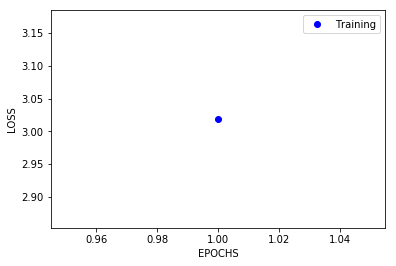

acc


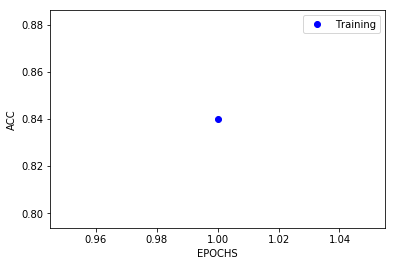

In [25]:
  ##  Test the predictions;  Should be on test set rather than full set. 
  predictions  =  model.predict(X_train)
  score        =  model.evaluate(X_train, y_train, verbose=0)

  print('Test loss:',     score[0])
  print('Test accuracy:', score[1])

  for stat in history.keys():
    print(stat)

    tstat  = history[stat]
    epochs = range(1, 1 + len(tstat))

    plt.plot(epochs, tstat, 'bo', label='Training')
    plt.xlabel('EPOCHS')
    plt.ylabel(stat.upper())
    plt.legend()
    plt.show()